In [26]:
from bed_reader import open_bed
from scipy.stats import mode
import numpy as np
bed_path = "/home/patrickgibbs/dsmwpred/patrick/Patrick_Aarhus/Aarhus-Visit/fine_mapping_simulation/small_chunks_current/genome_binary"

def get_bed(bfile, i):
    ukbb_path = f'{bfile}/sample_{i}.bed'
    bed = open_bed(ukbb_path)
    X = bed.read()
    # impute NaN to the mode
    modes = mode(X, nan_policy='omit').mode
    for i in range(X.shape[1]):
        X[np.isnan(X[:, i])] = modes[i]
    return X
X = get_bed(bed_path, 42
            )

X.shape

# compute sum/(n*2) accross columns
def compute_maf(X):
    return np.sum(X, axis=0)/(X.shape[0]*2)
compute_maf(X)[(X.shape[1])//2]


0.16078

In [65]:
import pandas as pd
from random import randint

CHROMOSOME = 0
START = 1
FINISH = 2
NUM_HUMAN_AUTOSOMES = 22

#### get bim for ukbb data and clean alittle i.e. rename columns ###
ukbb_bim = pd.read_csv("/faststorage/project/dsmwpred/data/ukbb/geno.bim", sep='\t', header=None)
# making another column containing the position of each SNP on  a chromosome as an integer
ukbb_bim['chrom_pos'] = [int(item[item.index(':') + 1:item.index('_')]) for item in ukbb_bim[1]]
ukbb_bim.rename(columns = {0:'chrom_number'}, inplace = True)

approx_chromosome_size = [max(ukbb_bim[ukbb_bim['chrom_number'] == chrom]['chrom_pos']) for chrom in range(1,NUM_HUMAN_AUTOSOMES + 1)]

def is_overlap(p_bounds, c_bound):
    for p_bound in p_bounds:
        if (c_bound[CHROMOSOME] == p_bound[CHROMOSOME]
            and pd.Interval(p_bound[START], p_bound[FINISH]).overlaps(pd.Interval(c_bound[START], c_bound[FINISH]))):
            print(p_bound, c_bound)
            return True
    return False 


def sample_snp(previous_bounds, size = 10**6):
    """
    Selects a random genome location of `size`. Also ensures that selected region has not before been selected
    and is thus not in previous_bounds
    """

    # selected a random snp from the bim
    snp = ukbb_bim.iloc[randint(0,len(ukbb_bim))]
    
    # extract snp infomation
    snp_chromosome = snp['chrom_number']
    snp_pos = snp['chrom_pos']

    # extract += 1mb from the randomly seleted SNP
    start = int(snp_pos - size/2)
    end = int(snp_pos + size/2 - 1)


    # if the the bound is outside the chromosome try again
    if (end < 0 or start > approx_chromosome_size[snp_chromosome - 1] 
             or is_overlap(previous_bounds, (snp_chromosome, start, end))):
        return sample_snp(bounds)
    

    return snp_chromosome, start, end
    

# select 200 1mb regions
bounds = []
for i in range(200):
    bounds.append(sample_snp(bounds))

    with open(f'genome_regions_map/genome_sample_{i}', 'w') as f:
        f.write(f'{bounds[i][CHROMOSOME]} {bounds[i][START]} {bounds[i][FINISH]} sample_{i}')
   

(17, 45609371, 46609370) (17, 44862645, 45862644)
(10, 79719244, 80719243) (10, 79137685, 80137684)
(11, 106896158, 107896157) (11, 106725455, 107725454)
(7, 70494529, 71494528) (7, 69719601, 70719600)
(7, 150407352, 151407351) (7, 150975924, 151975923)
(3, 23663921, 24663920) (3, 24099023, 25099022)
(2, 3027789, 4027788) (2, 3265496, 4265495)
(6, 30542306, 31542305) (6, 30344116, 31344115)
(6, 837311, 1837310) (6, 1346219, 2346218)
(1, 119353544, 120353543) (1, 119353544, 120353543)
(2, 235207441, 236207440) (2, 235667498, 236667497)
(11, 134250249, 135250248) (11, 133284410, 134284409)
(12, 9102099, 10102098) (12, 9286707, 10286706)
(14, 92273663, 93273662) (14, 92604090, 93604089)
(6, 30542306, 31542305) (6, 30412481, 31412480)
(1, 13636289, 14636288) (1, 14478743, 15478742)
(7, 29877987, 30877986) (7, 30587602, 31587601)
(2, 3027789, 4027788) (2, 2292967, 3292966)
(10, 78144015, 79144014) (10, 77555260, 78555259)
(7, 150407352, 151407351) (7, 150990078, 151990077)
(7, 66674584, 676

In [166]:
### simulate phenotypes
import os
from pandas_plink import read_plink
import numpy as np

snp_info_output_path = '/home/patrickgibbs/dsmwpred/patrick/Patrick_Aarhus/Aarhus-Visit/fine_mapping_simulation/one_marker_phenotypes/casual_snp_info'
phenotypes_output_path = '/home/patrickgibbs/dsmwpred/patrick/Patrick_Aarhus/Aarhus-Visit/fine_mapping_simulation/one_marker_phenotypes/phenotypes'
var_g = 0.005

for sample in range(70,200):

    # read in genomic regions
    ukbb_path = f'/home/patrickgibbs/dsmwpred/patrick/Patrick_Aarhus/Aarhus-Visit/fine_mapping_simulation/genome_regions/genome_sample_{sample}'
    bim_df = pd.read_csv(f'{ukbb_path}.bim', delimiter='\t', header = None)
    bim_df.columns = ['Chromosome code', 'Variant identifier', 'Position in morgans or centimorgans', 'Base-pair coordinate ', 'Allele 1', 'Allele 2']
    fam_df = pd.read_csv(f'{ukbb_path}.fam', delimiter=' ', header = None)


    (bim, fam, bed) = read_plink(ukbb_path, verbose=False)
    X = bed.compute().T
    num_markers = X.shape[1]


    non_nan_columns = ~np.any(np.isnan(X), axis=0)
    def get_casual(snp_range):
        casual = randint(0,snp_range-1)
        if not non_nan_columns[casual]:
            return get_casual(snp_range)
        return casual

    casual = get_casual(num_markers)

    y_g = 1 * X[:,casual] 

    var_e = 1 - var_g
    y = (y_g) * (0.05 / np.std(y_g)**2) + np.random.normal(0,var_e, size= (len(y_g)))

    casual_info = bim_df.iloc[casual].copy()
    casual_info['heritability'] = var_g
    casual_info['snp_index_in_chunk'] = casual
    casual_info = pd.DataFrame(casual_info)
    casual_info.to_csv(f'{snp_info_output_path}/snp_info_sample_{sample}', sep='\t', header = False)

    phenotype_df = pd.DataFrame({'acc1': fam_df[0], 'acc2': fam_df[1], 'pheno': y})
    phenotype_df.to_csv(f'{phenotypes_output_path}/pheno_{sample}', sep=' ', header=None, index=None)


/scratch/usertmp/ipykernel_4159452/2836088389.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  (bim, fam, bed) = read_plink(ukbb_path, verbose=False)
/scratch/usertmp/ipykernel_4159452/2836088389.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  (bim, fam, bed) = read_plink(ukbb_path, verbose=False)
/scratch/usertmp/ipykernel_4159452/2836088389.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  (bim, fam, bed) = read_plink(ukbb_path, verbose=False)
/scratch/usertmp/ipykernel_4159452/2836088389.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  (bim, fam, bed) = read_plink(ukbb_path, verbose

KeyboardInterrupt: 

/scratch/usertmp/ipykernel_4159452/1588954452.py:35: RuntimeWarning: divide by zero encountered in log
  p_vals = -np.log(np.array(df['P']))
/scratch/usertmp/ipykernel_4159452/1588954452.py:35: RuntimeWarning: divide by zero encountered in log
  p_vals = -np.log(np.array(df['P']))
/scratch/usertmp/ipykernel_4159452/1588954452.py:35: RuntimeWarning: divide by zero encountered in log
  p_vals = -np.log(np.array(df['P']))
/scratch/usertmp/ipykernel_4159452/1588954452.py:35: RuntimeWarning: divide by zero encountered in log
  p_vals = -np.log(np.array(df['P']))
/scratch/usertmp/ipykernel_4159452/1588954452.py:35: RuntimeWarning: divide by zero encountered in log
  p_vals = -np.log(np.array(df['P']))
/scratch/usertmp/ipykernel_4159452/1588954452.py:35: RuntimeWarning: divide by zero encountered in log
  p_vals = -np.log(np.array(df['P']))
/scratch/usertmp/ipykernel_4159452/1588954452.py:35: RuntimeWarning: divide by zero encountered in log
  p_vals = -np.log(np.array(df['P']))
/scratch/user

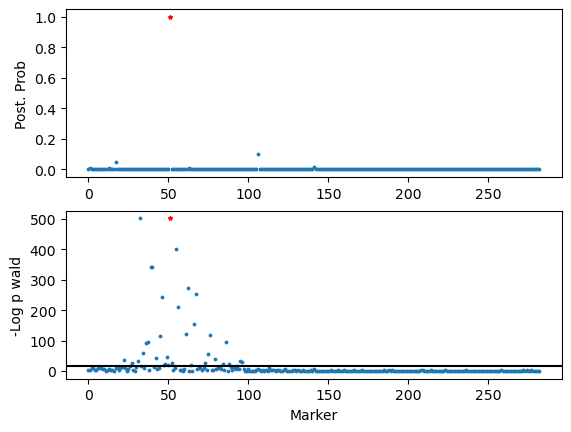

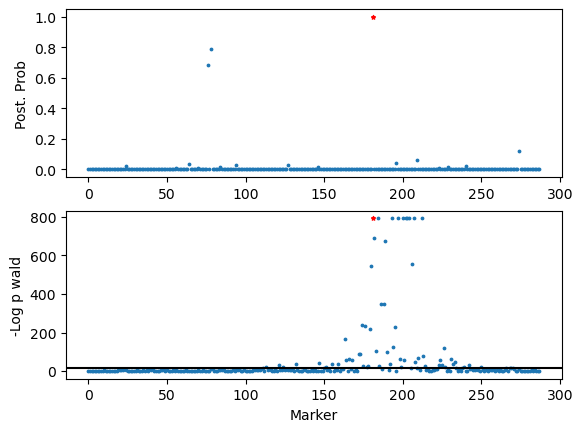

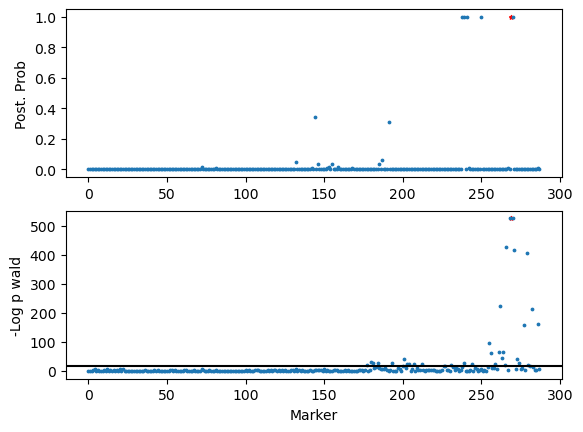

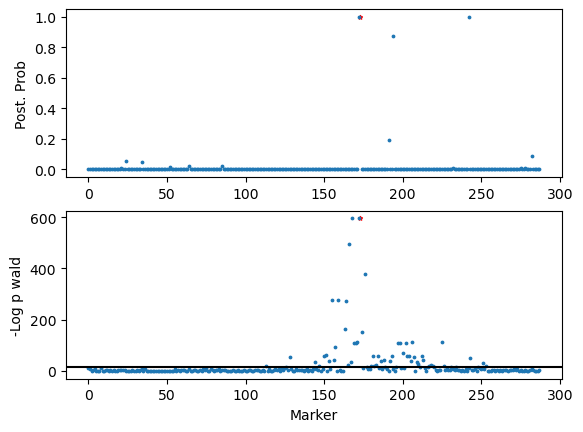

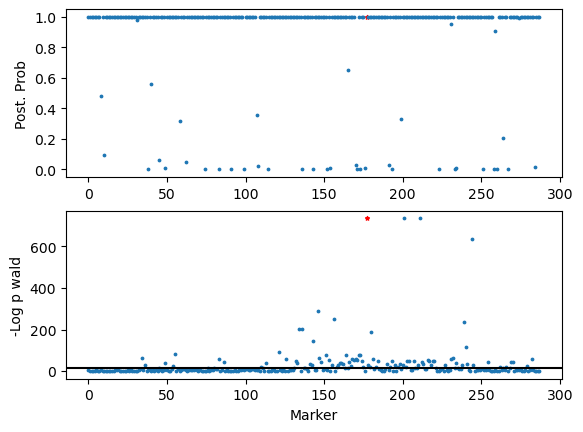

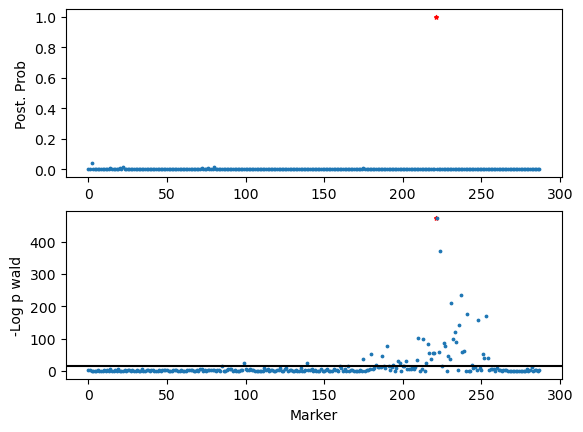

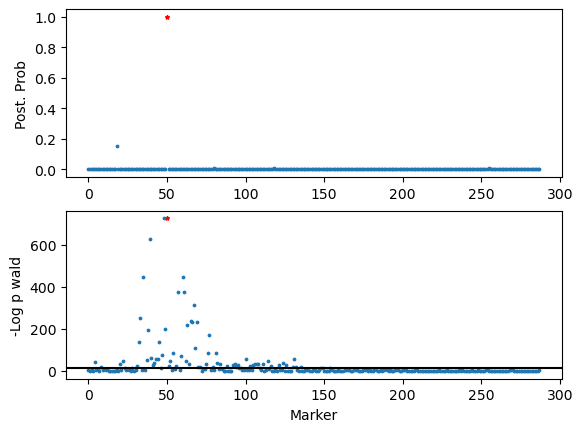

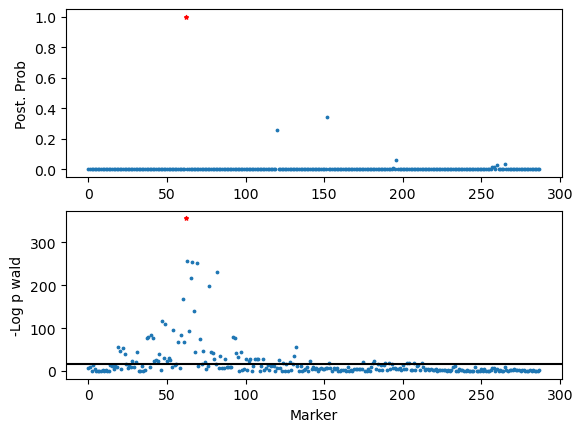

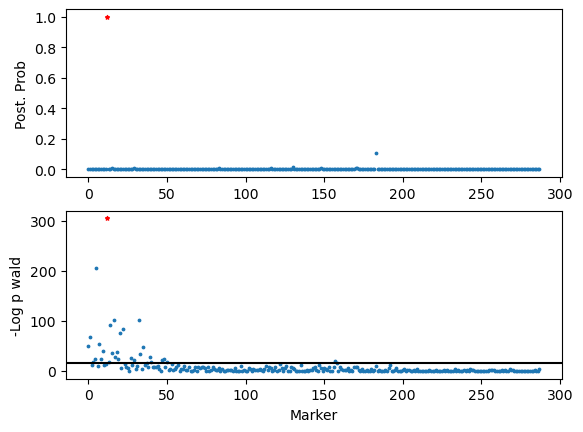

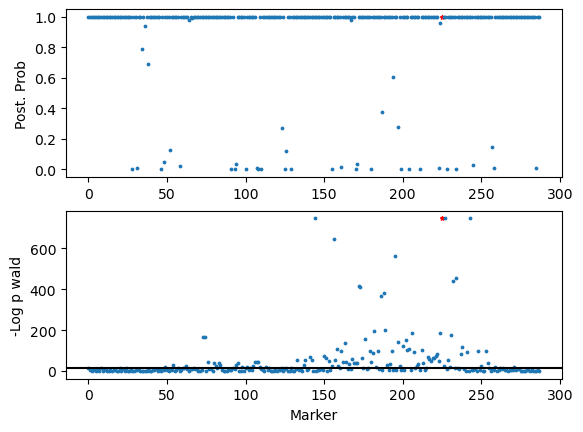

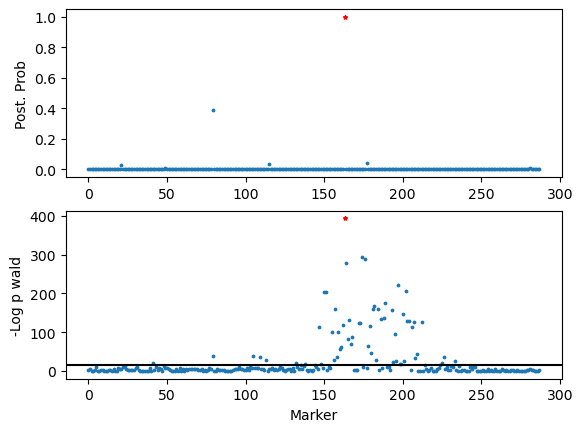

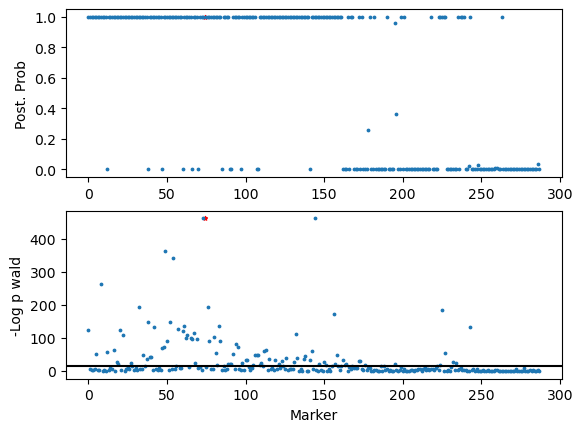

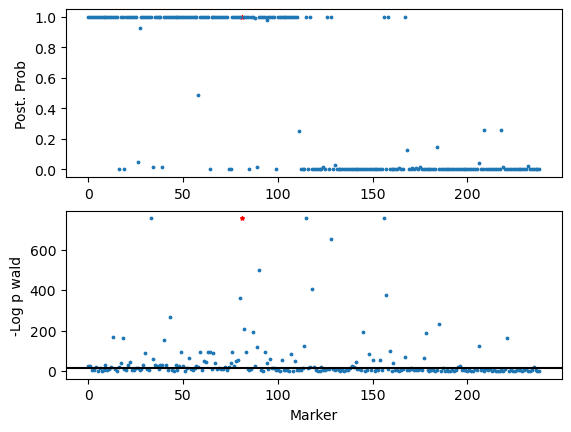

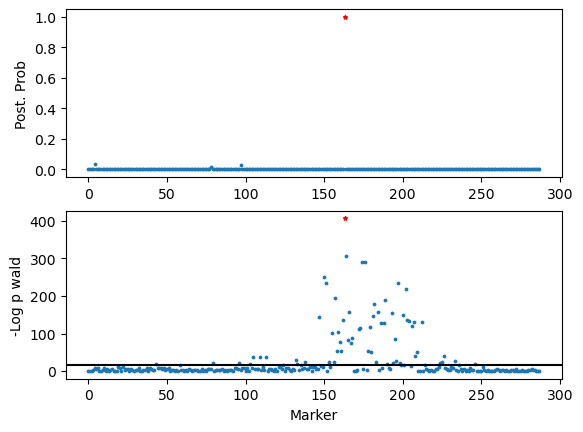

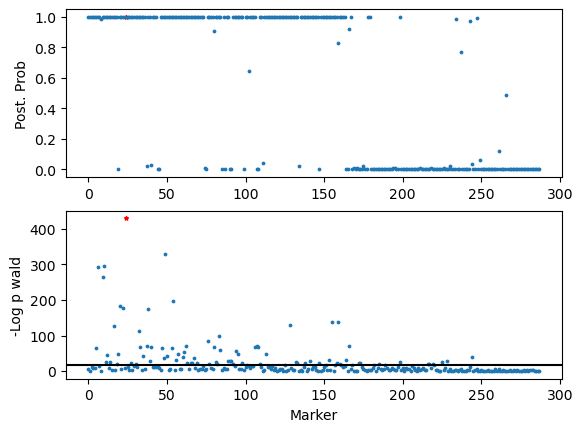

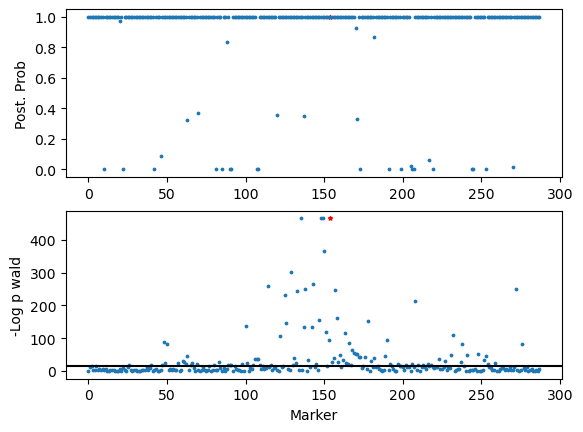

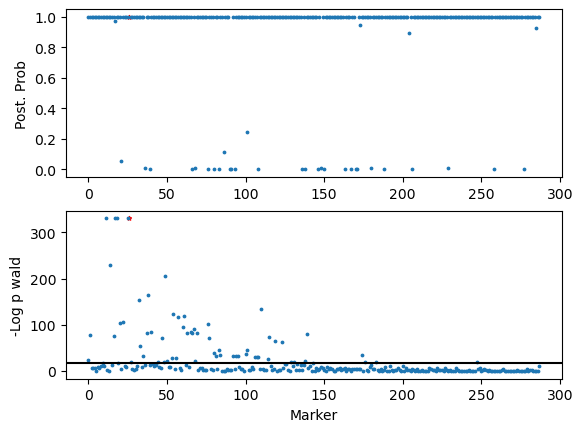

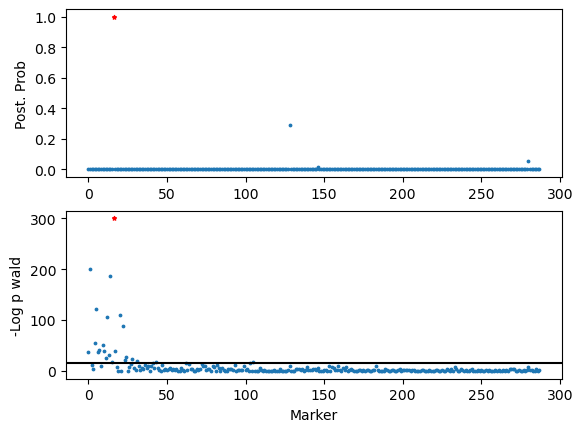

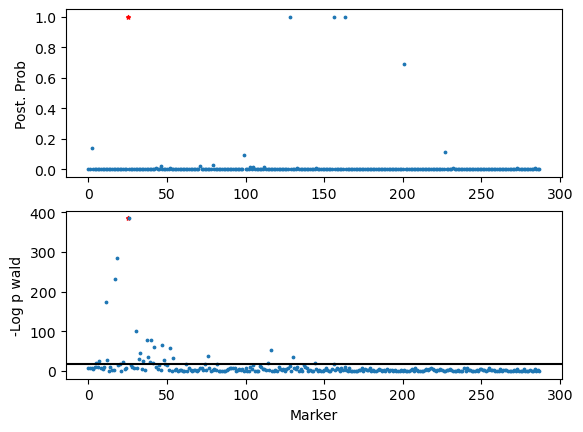

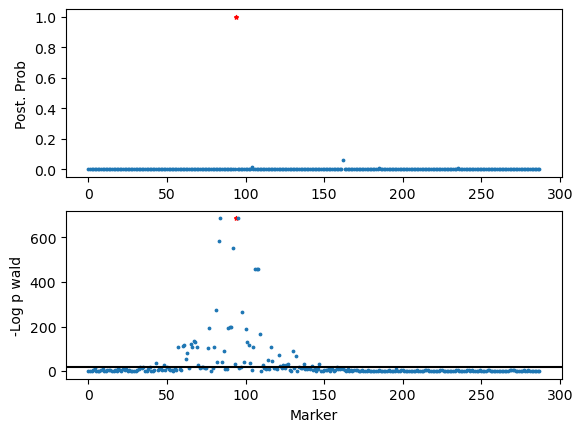

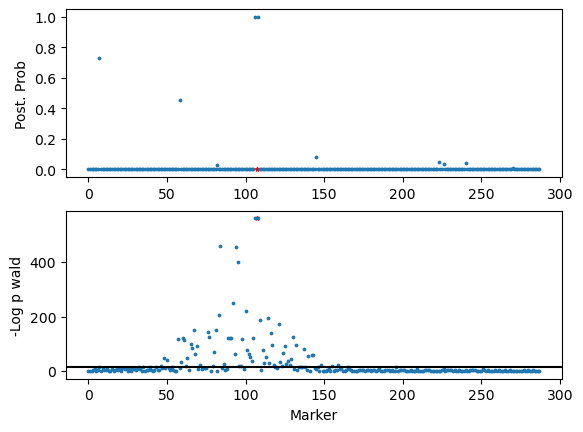

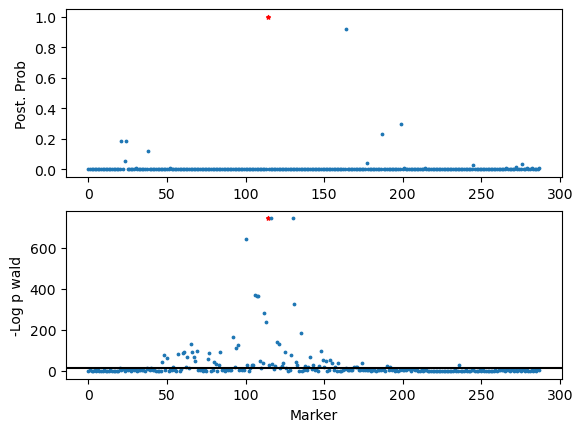

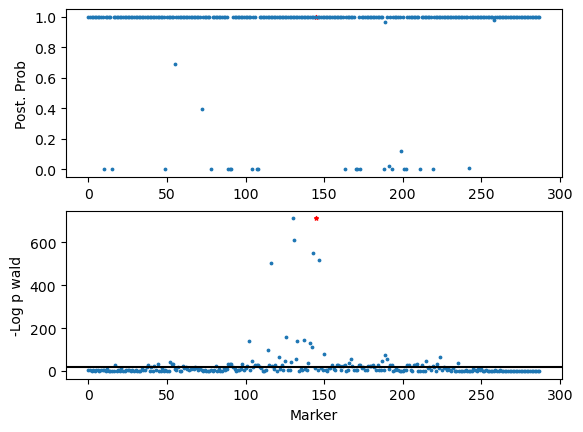

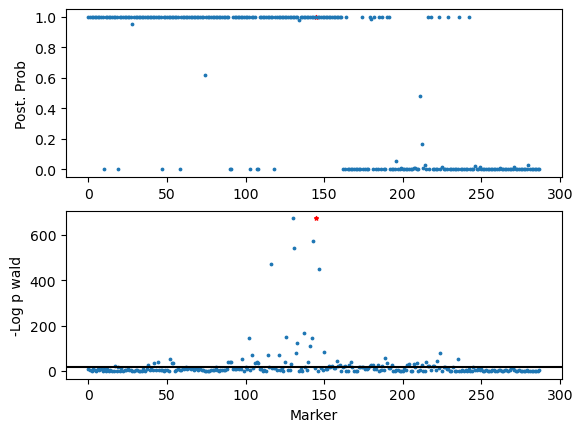

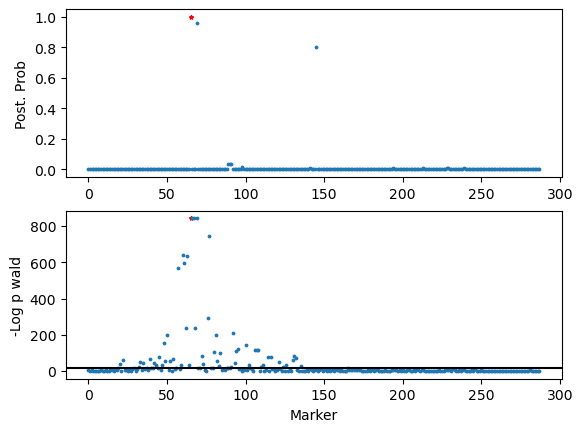

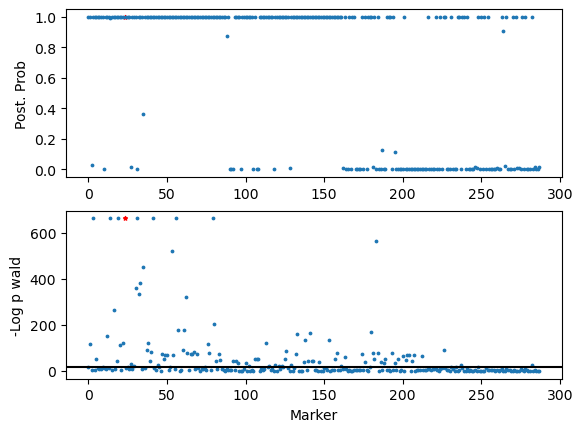

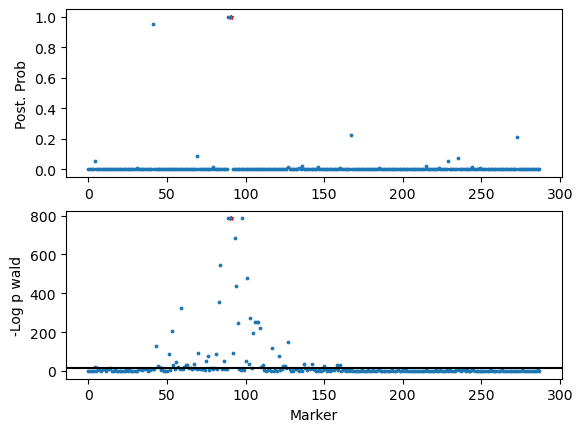

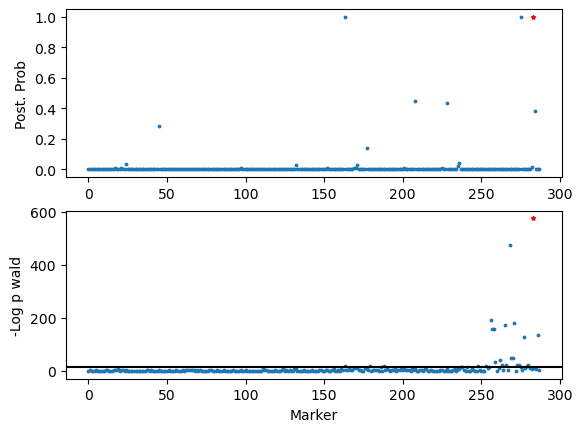

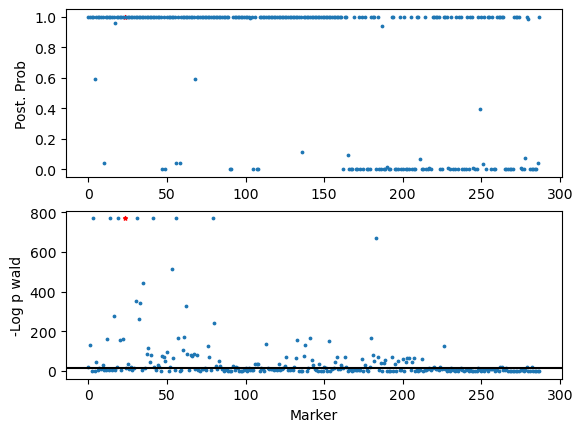

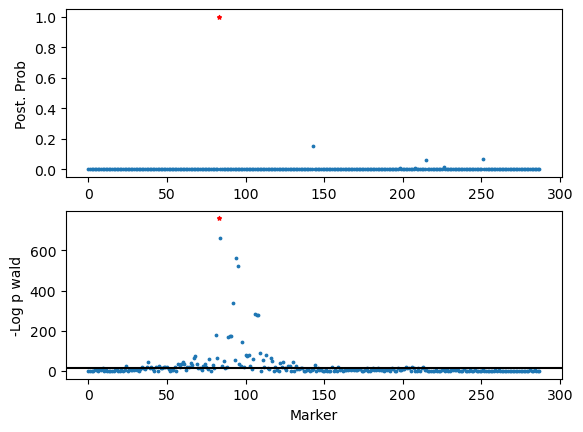

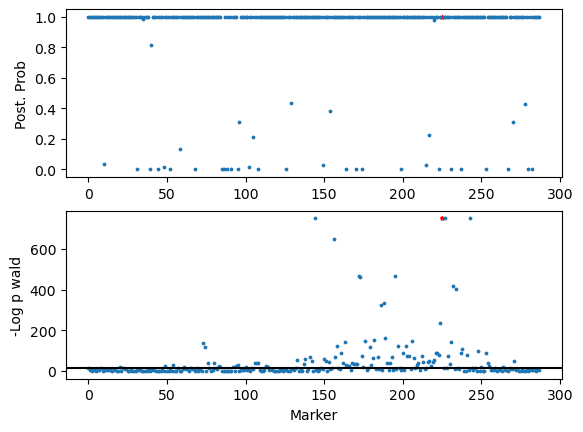

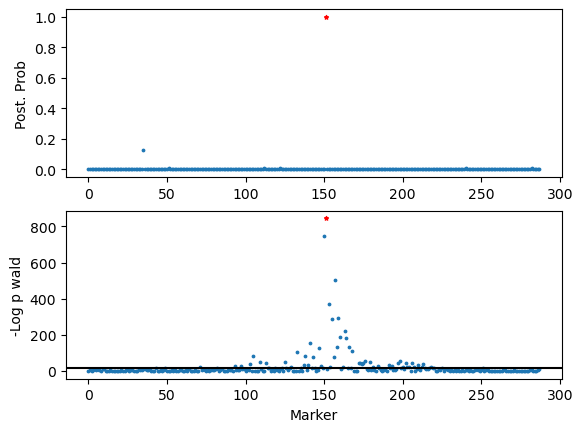

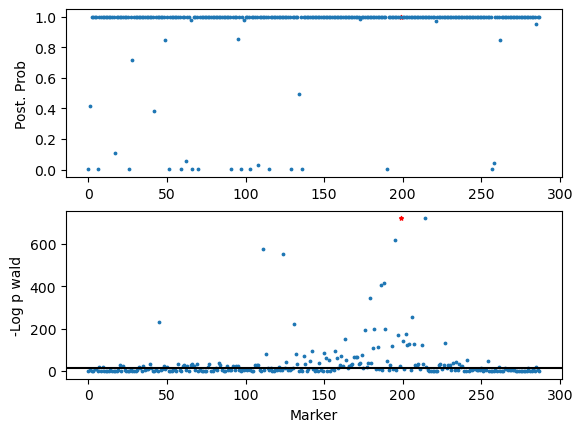

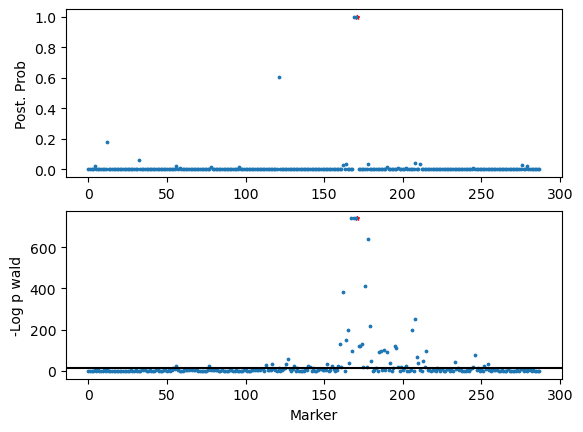

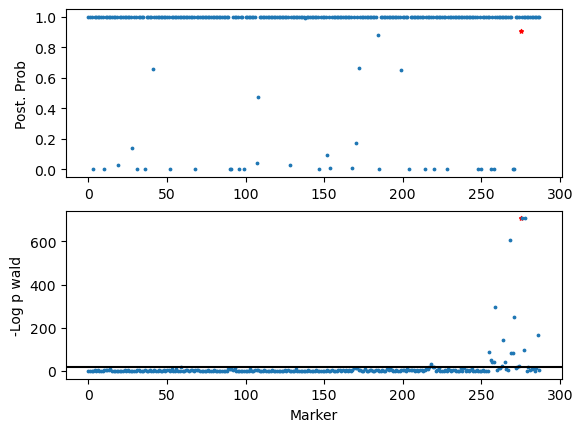

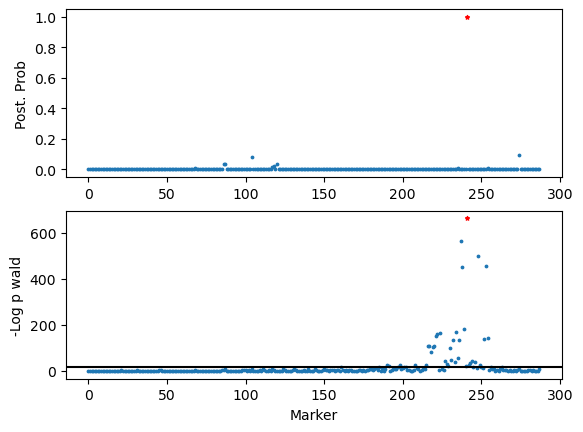

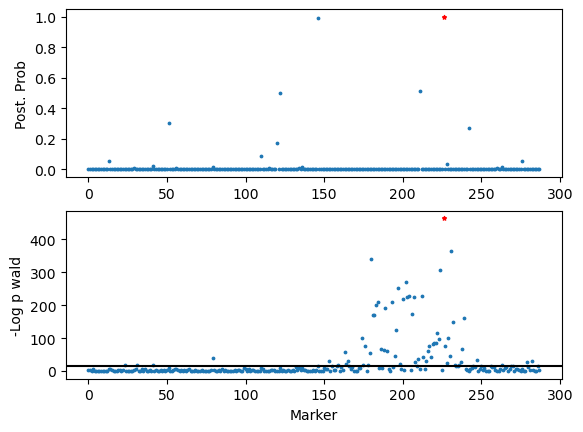

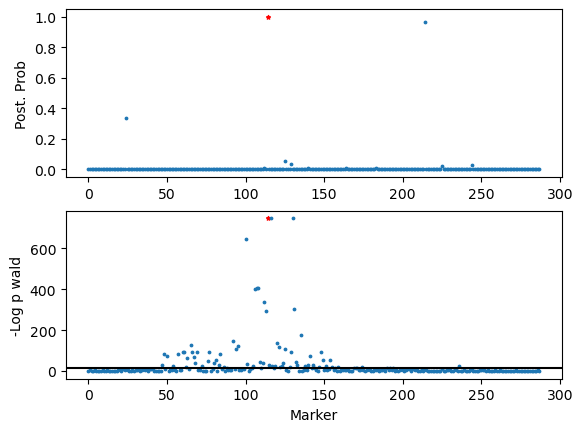

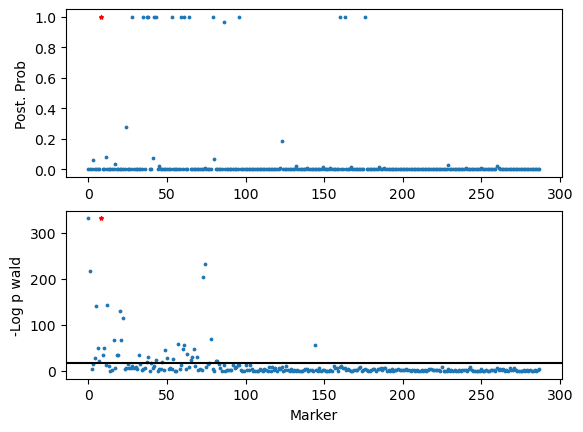

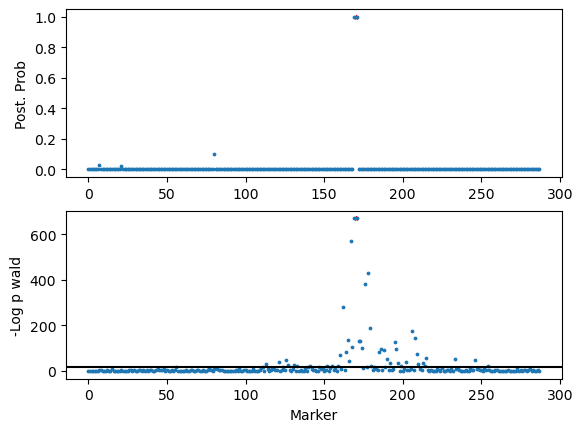

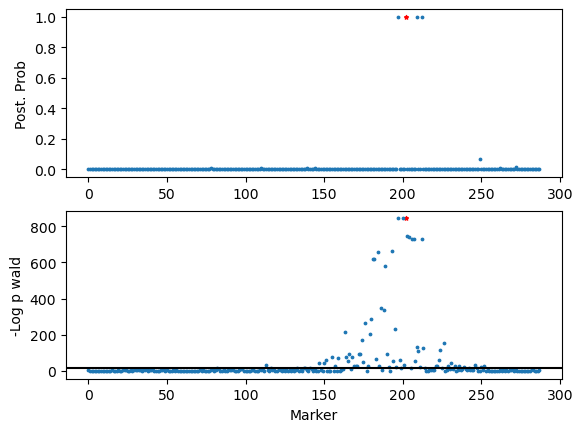

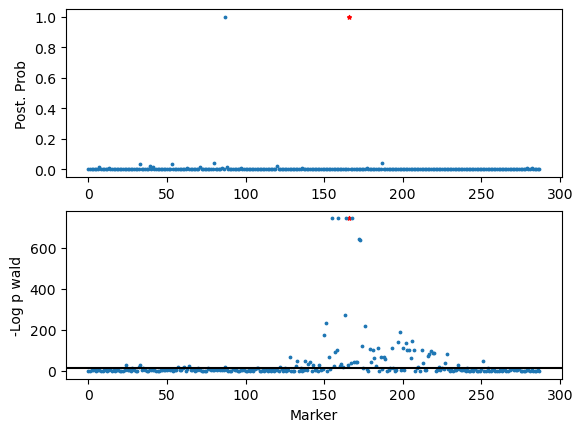

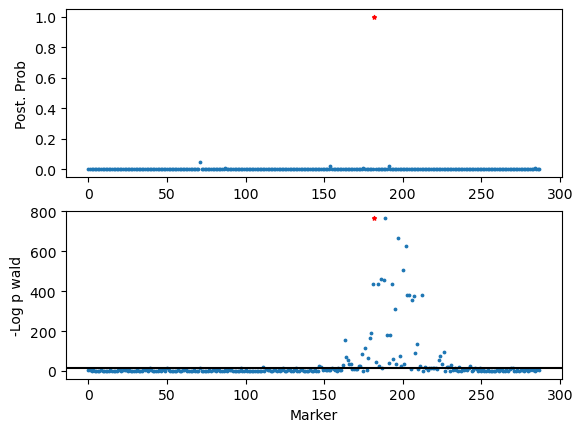

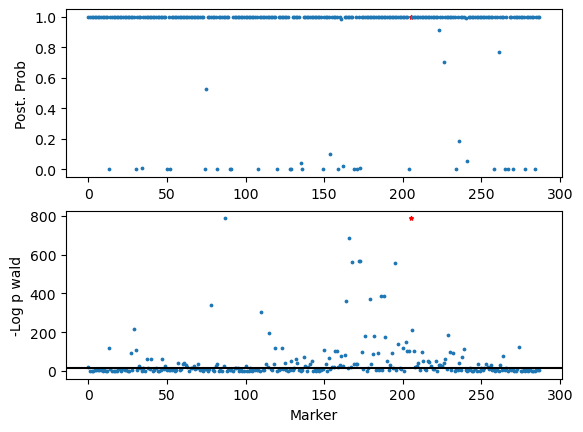

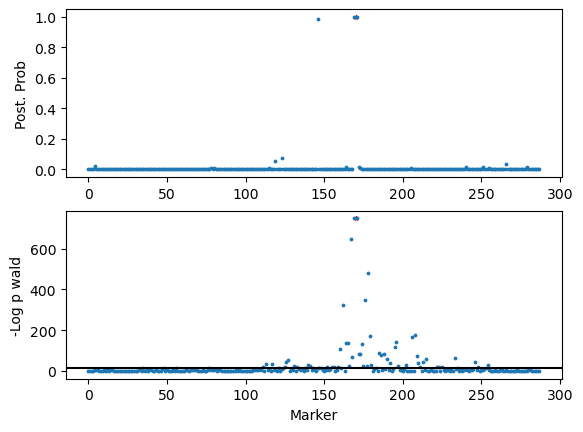

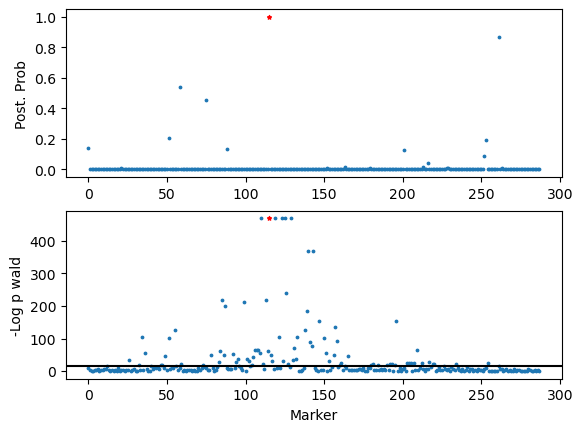

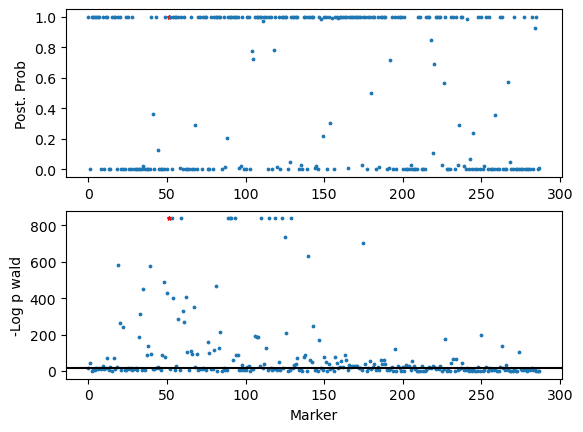

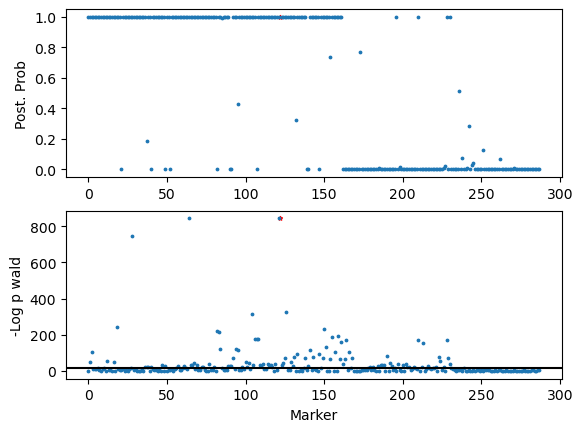

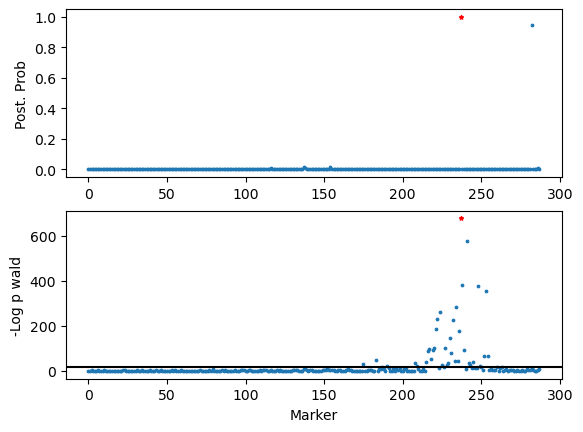

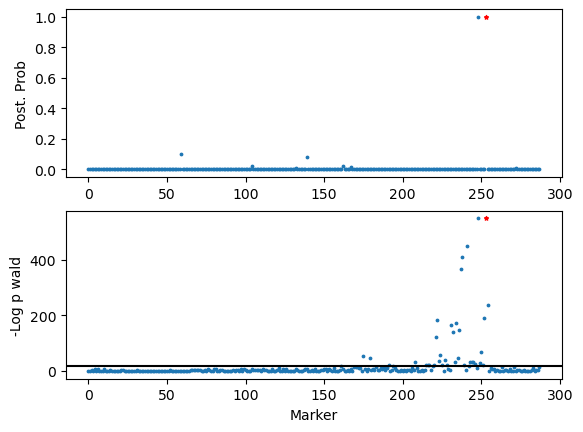

In [209]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

casual_size = 8 # Larger size for the ith point
size = 3

for sample in range(50):
    real_snp_location_df = pd.read_csv(f'one_marker_phenotypes/casual_snp_info/snp_info_sample_{sample}', sep='\t',header=None)
    casual_i = int(list(real_snp_location_df.set_index(0).loc['snp_index_in_chunk'])[0])

    gwas_path = f'fine_map_gwas/gwas_sample_{sample}.pvalues'
    bayesr_path = f'fine_map_bayesr/bayesr_sample_{sample}.probs'
    output_path = f'figures/sample_{sample}'

    df = pd.read_csv(bayesr_path, sep=' ')
    probs = np.array(df['Probability'])

    marker_chrom = [int(loci[:loci.index(':')]) for loci in df['Predictor']]
    colors = ['blue' if chrom % 2 == 0 else 'red' for chrom in marker_chrom]

    #### make a figure with GWAS and Post.Prob ####

    # Post. Prob Plot 
    fig, axs = plt.subplots(2, 1)
    axs[0].scatter(np.arange(len(probs))[casual_i], probs[casual_i], s=casual_size, marker = '*', c='red')
    axs[0].scatter(np.delete(np.arange(len(probs)), casual_i), np.delete(probs, casual_i), s=size)

    axs[0].set_ylabel("Post. Prob")


    # Basic GWAS
    p_critical = 5*10**(-8)
    df = pd.read_csv(gwas_path, sep=' ')
    p_vals = -np.log(np.array(df['P']))

    inf_positions = np.isinf(p_vals)

    # Step 2: Find the maximum of non-infinite elements
    max_value = np.max(p_vals[~inf_positions])

    # Step 3: Replace inf with max_value + 100
    p_vals[inf_positions] = max_value + 100

    axs[1].scatter([casual_i],p_vals[casual_i], s=casual_size, marker = '*', c='red')
    axs[1].scatter(np.delete(np.arange(len(probs)), casual_i),np.delete(p_vals, casual_i), s=size)
    axs[1].axhline(y=-np.log(p_critical), color='black', linestyle='-')

    axs[1].set_xlabel("Marker")
    axs[1].set_ylabel("-Log p wald")
    plt.savefig(f'{output_path}.png')

In [123]:
genome_regions

['genome_sample_47',
 'genome_sample_30',
 'genome_sample_184',
 'genome_sample_117',
 'genome_sample_160',
 'genome_sample_75',
 'genome_sample_91',
 'genome_sample_158',
 'genome_sample_152',
 'genome_sample_125',
 'genome_sample_29',
 'genome_sample_54',
 'genome_sample_23',
 'genome_sample_104',
 'genome_sample_173',
 'genome_sample_179',
 'genome_sample_197',
 'genome_sample_7',
 'genome_sample_82',
 'genome_sample_11',
 'genome_sample_66',
 'genome_sample_88',
 'genome_sample_141',
 'genome_sample_136',
 'genome_sample_131',
 'genome_sample_146',
 'genome_sample_0',
 'genome_sample_85',
 'genome_sample_61',
 'genome_sample_16',
 'genome_sample_174',
 'genome_sample_103',
 'genome_sample_190',
 'genome_sample_109',
 'genome_sample_59',
 'genome_sample_24',
 'genome_sample_53',
 'genome_sample_128',
 'genome_sample_122',
 'genome_sample_155',
 'genome_sample_72',
 'genome_sample_78',
 'genome_sample_96',
 'genome_sample_183',
 'genome_sample_167',
 'genome_sample_110',
 'genome_sam

In [2]:
import numpy as np
from scipy.stats import mode
X = np.array([[1, 2, np.nan],
                 [4, np.nan, 6],
                 [1, 2, 6]])


# impute NaN to the mode
modes = mode(X, nan_policy='omit').mode
for i in range(X.shape[1]):
    X[np.isnan(X[:,i])] = modes[i]

X

array([[6., 6., 6.],
       [2., 2., 2.],
       [1., 2., 6.]])

In [ ]:
#### Simulate Paper Claim

